# 🥊 Aspect Based Sentiment Analysis of <span style="color:red">YouTube</span> Comments
## Case Study: boxing match between Tyson Fury and Oleksander Usyk

<img src="FP_design.png">

## **Table of Contents**

1. [Introduction](#1.-Introduction)

2. [Import Libraries](#2.-Import-Libraries)

3. [Data Collection](#3.-Data-Collection)
   - [Setting Up YouTube API](#Setting-Up-YouTube-API)
   - [Data Storage Initialization](#Data-Storage-Initialization)
   - [Video Retrieval & Comments Extraction](#Video-Retrieval-&-Comments-Extraction)
   <!-- - [Comments Extraction](#Comments-Extraction)    -->  
   <br>
4. [EDA of Data Collection Dataset](#4.-EDA-of-Data-Collection-Dataset)
   - [Understand video metadata](#Understand-video-metadata) 

6. [Data Preprocessing](#5.-Data-Preprocessing)
    - [Duplicate Elimination](#Duplicate-Elimination)
    - [Comments Cleaning](#Comments-Cleaning)
    - [Non-English Comments Removal](#Non-English-Comments-Removal)

      
5. [Feature Engineering](#6.-Feature-Engineering)
    - [Engagement Feature Creation](#Engagement-Feature-Creation)
    - [Engagement-Based Filtering](#Engagement-Based-Filtering)
    - [Keyword-Based Categorisation](#Keyword-Based-Categorisation)
    - [Category Filtering](#Category-Filtering)


7. [Annotation](#7.-Annotation)
   - [Humman Feedback Annotation](#Humman-Feedback-Annotation)
   - [Annotation Scaling](#Annotation-Scaling)
   
8. [Secondary Exploratory Data Analysis (EDA)](#8.-Secondary-Exploratory-Data-Analysis-(EDA))
   - [Prompt Engineering Accuracy](#Prompt-Engineering-Accuracy)
   - [Sentiment-Distribution-of-Annotated-Comments](#Sentiment-Distribution-of-Annotated-Comments)
   - [Combined-Sentiment-Distribution](#Combined-Sentiment-Distribution)
   - [WordCloud](#WordCloud)
   - [Length Distribution Post-Cleaning](#Length-Distribution-Post-Cleaning)
9. [Datasets Preparation](#9.-Datasets-Preparation)
    - [Keyword-Based Dataset](#Keyword-Based-Dataset)
    - [Balanced Dataset](#Balanced-Dataset)
    - [Auxiliary Dataset](#Auxiliary-Dataset)
10. [Baseline Model Evaluation](#10.-Baseline-Model-Evaluation)
    - [Bag of Words (BoW) with Multinomial Naive Bayes (MB)](#Bag-of-Words-(BoW)-with-Multinomial-Naive-Bayes-(MB))
    - [Logistic Regression (LR) TF-IDF with with N-grams (1,3)](#Logistic-Regression-(LR)-TF-IDF-with-N-grams-(1,3))
    - [Support Vector Classifier (SVC) TF-IDF with N-grams (1,3)](#Support-Vector-Classifier-(SVC)-TF-IDF-with-N-grams-(1,3))
    - [Evaluate Machine Learning Models](#Evaluate-Machine-Learning-Models)
  
11. [BERT (Bidirectional Encoder Representations from Transformers) Model](#11.-BERT-(Bidirectional-Encoder-Representations-from-Transformers)-Model)
    - [Data Preprocessing and Splitting](#Data-Preprocessing-and-Splitting)
    - [Custom Sentiment Dataset Class](#Custom-Sentiment-Dataset-Class)
    - [Data Loader Creation](#Data-Loader-Creation)
    - [Sentiment Classifier Neural Network](#Sentiment-Classifier-Neural-Network)
    - [Training Epoch Function](#Training-Epoch-Function)
    - [Evaluation Function for the Model](#Evaluation-Function-for-the-Model)
    - [Model Training and Evaluation](#Model-Training-and-Evaluation)
    - [Consolidating BERT Model Metrics](#Consolidating-BERT-Model-Metrics)
    - [Extracting Optimal BERT Model Performance](#Extracting-Optimal-BERT-Model-Performance)
    - [Visualising Model Performance Across Datasets](#Visualising-Model-Performance-Across-Datasets)
 
13. [Evaluation](#12.-Evaluation)
    - [Model Performance Breakdown by Dataset and Fighter Sentiment](#Model-Performance-Breakdown-by-Dataset-and-Fighter-Sentiment)
    - [Comparative Analysis of Model Accuracy Across Different Datasets](#Comparative-Analysis-of-Model-Accuracy-Across-Different-Datasets)


## 1. Introduction
This project, focuses on the innovative application of Aspect-Based Sentiment Analysis (ABSA) techniques on YouTube comments, specifically in the realm of boxing. The project utilizes a case study approach, centering on the high-profile boxing match between Tyson Fury and Oleksandr Usyk, to explore public opinion and sentiment dynamics within the YouTube community.

The primary objective is to develop a sophisticated system capable of extracting, processing, and analyzing sentiments from YouTube comments, focusing on fighters’ names as aspects mentioned in the comments. This system leverages advanced NLP and machine learning techniques, particularly the BERT model, to deeply understand public sentiment and opinion in user-generated content.

The project aims to offer valuable insights into how fans perceive and discuss key aspects of boxing matches, providing a unique lens through which to view public sentiment in sports. It covers a comprehensive journey from data extraction to actionable insights, aiming to serve as a tool for researchers, marketing analysts, and content creators in the sports domain.

## 2. Import Libraries

In [23]:
# Common Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# Libraries Part of This Project
from src.youtube_scrapping import YouTube_Scrapper
from src.data_saver import DataSaver
from src.data_loader import DataLoader
from src.feature_engineering import FeatureEngineering
from src.data_preprocessing import Preprocessor
from src.annotator import Annotator
# Do Not Show Warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Autoreload files 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Data Collection


### Setting Up <span style="color:red;">YouTube</span> API

🚀 Initialize YouTube Scrapper<br>
🔍 Search Term<br>
📅 Publication Date<br>
⏳ Video Duration<br>
⛔ Result Limitation<br>

In [381]:
# YouTube Scrapper initialization
youtube_scrapper = YouTube_Scrapper()

# Defining Search Criteria
API_KEY = youtube_scrapper.get_api_key()
SEARCH_TERM = 'Fury vs Usyk'  
PUBLISHED_AFTER = '2023-11-20T00:00:00Z'  
PUBLISHED_BEFORE = '2024-2-19T00:00:00Z'  
VIDEO_DURATION = 'medium'  # Videos between 4 mins and 20 mins
MAX_RESULTS = 50

### Data Storage Initialization

In [17]:
# Initiaze Data Saver class
ds = DataSaver()
# Initialise Data Loader Class 
dl = DataLoader()


### Video Retrieval & Comments Extraction

- **Search-Based Video Retrieval**: Fetch videos that match specified search criteria, ensuring relevance to the research topic or interest area.
- **Comments Extraction**: Collect comments from retrieved videos to analyze viewer engagement and sentiment.
- **Data Preservation**: Store the resulting dataset in a CSV file for ease of access, sharing, and further analysis.



In [383]:
# Get YouTube videos based on Search Term, publishing date and video length, max results 
videos_df = youtube_scrapper.get_videos(API_KEY, SEARCH_TERM, PUBLISHED_AFTER,PUBLISHED_BEFORE, VIDEO_DURATION, MAX_RESULTS)

# Fetch videos comments from videos IDs
youtube_videos_and_comments = youtube_scrapper.get_video_comments(videos_df)

# Save comments dataframe 
ds.save_to_csv(youtube_videos_and_comments, "data/raw/youtube_videos_comments.csv")

File data/raw/youtube_videos_comments.csv already exists! Overwrite (O), Append (A), Cancel (C)?  A


Data appended to: data/raw/youtube_videos_comments.csv


## 4. EDA of Data Collection Dataset

- **Initial Data View**: Use `.head()` to display the first 5 rows, offering an early look at the data's structure and values.
- **Data Shape**: Apply `.shape` to reveal dataset dimensions, indicating total rows and columns.
- **Data Types**: Use `.info` to identify data types. 
- **Missing Values**: Identify missing entries with `.isnull().sum()`, crucial for data cleaning.
- **Duplicate Entries**: Detect duplicates via `.duplicated().sum()` to ensure data uniqueness.
- **Engagement Metrics**: Analyze 'view counts' and 'likes' to gauge audience interaction, employing descriptive statistics and plots.
- **Content Analysis**: Extract frequent terms, gauge sentiment hints, and visualize text length distribution to understand content characteristics.
- **Visualizations**: Use word clouds for term frequency, histograms for numerical data distribution, and bar charts for categorical data analysis.


**Show first 5 rows of Data Collected**

In [503]:
# Load youtube_videos_and_comments 
youtube_videos_and_comments = dl.load_data("data/raw/youtube_videos_comments.csv")

# Display the last 5 rows of the merged videos and comments dataframe
youtube_videos_and_comments.head(5)

,video_id,title,published_date,duration,description,like_count,view_count,comment_count,comment,comment_likes,total_reply_count
57944,D6g7u_wXBuY,"""I am DONE with betting against Oleksandr Usyk!""",2024-01-21T12:00:09Z,PT10M50S,Chris Mannix and Sergio Mora debate the upcomi...,457,24949,378,"USYK BEAT TYSON FURY GUYS, THIS FIGHT GO SO ...",24,4
57945,D6g7u_wXBuY,"""I am DONE with betting against Oleksandr Usyk!""",2024-01-21T12:00:09Z,PT10M50S,Chris Mannix and Sergio Mora debate the upcomi...,457,24949,378,Ngannou showed how you to stop Tyson using his...,2,7
57946,D6g7u_wXBuY,"""I am DONE with betting against Oleksandr Usyk!""",2024-01-21T12:00:09Z,PT10M50S,Chris Mannix and Sergio Mora debate the upcomi...,457,24949,378,I think we are going to see the Gypsy King in ...,7,5
57947,D6g7u_wXBuY,"""I am DONE with betting against Oleksandr Usyk!""",2024-01-21T12:00:09Z,PT10M50S,Chris Mannix and Sergio Mora debate the upcomi...,457,24949,378,This fight will show you how chinny fury is. W...,39,11
57948,D6g7u_wXBuY,"""I am DONE with betting against Oleksandr Usyk!""",2024-01-21T12:00:09Z,PT10M50S,Chris Mannix and Sergio Mora debate the upcomi...,457,24949,378,"Luke is 6'7 not 6,9",48,11


**Data Shape**

In [506]:
# Shape of youtube_videos_and_comments dataframe
print('Data Shape: ', youtube_videos_and_comments.shape)

Data Shape:  (57949, 11)


**Data types**

In [548]:
youtube_videos_and_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57949 entries, 0 to 57948
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           57949 non-null  object             
 1   title              57949 non-null  object             
 2   published_date     57949 non-null  datetime64[ns, UTC]
 3   duration           57949 non-null  object             
 4   description        57733 non-null  object             
 5   like_count         57949 non-null  int64              
 6   view_count         57949 non-null  int64              
 7   comment_count      57949 non-null  int64              
 8   comment            57942 non-null  object             
 9   comment_likes      57949 non-null  int64              
 10  total_reply_count  57949 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 4.9+ MB


**Missing values**

In [507]:
youtube_videos_and_comments.isnull().sum()

video_id               0
title                  0
published_date         0
duration               0
description          216
like_count             0
view_count             0
comment_count          0
comment                7
comment_likes          0
total_reply_count      0
dtype: int64

**Duplicates**

In [508]:
print('Number of duplicate rows: ', len(youtube_videos_and_comments[youtube_videos_and_comments.duplicated()]))

Number of duplicate rows:  1297


### Understand video metadata

**Plot Views and Likes Distribution with Histogram**

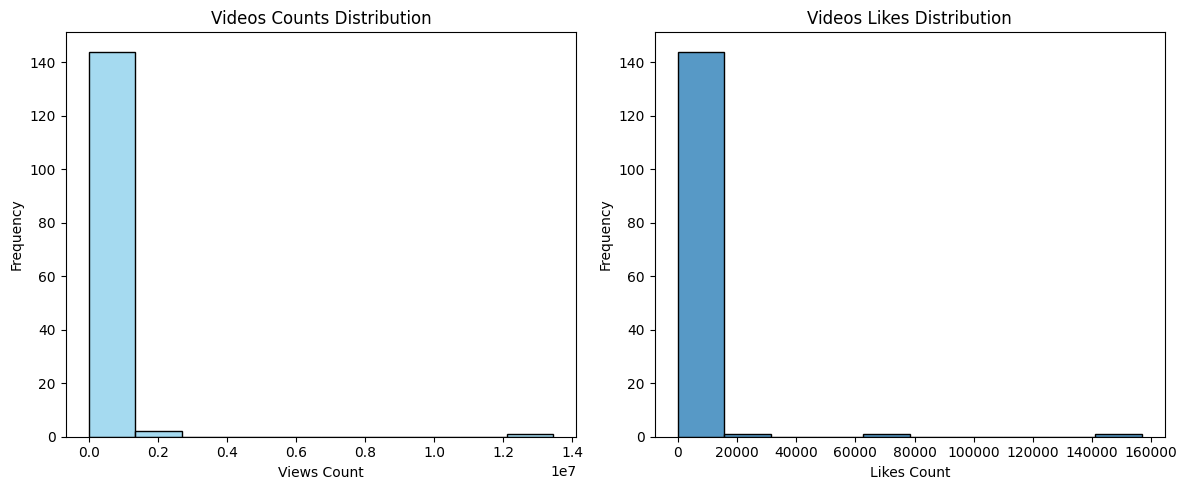

In [525]:
# group by video id and show the view count per video
unique_video_views = youtube_videos_and_comments.drop_duplicates(subset=['video_id', 'view_count'])
# group by video id and show the view count per video
unique_video_likes = youtube_videos_and_comments.drop_duplicates(subset=['video_id', 'like_count'])

# Create a figure and two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot
sns.histplot(unique_video_views['view_count'], ax=ax1, bins=10, color='skyblue')
ax1.set_title('Videos Counts Distribution')
ax1.set(xlabel='Views Count', ylabel='Frequency')

# Second scatter plot (for the sake of demonstration, let's use a different style)
sns.histplot(unique_video_likes['like_count'], ax=ax2, bins=10)
ax2.set_title('Videos Likes Distribution')
ax2.set(xlabel='Likes Count', ylabel='Frequency')

# Adjust spacing between the plots
plt.tight_layout()
plt.show();

**Sample Bar chart of YouTube videos view counts and likes**

As we can see from the histograms the distribution of views and likes is almost identical it just differs in scale!

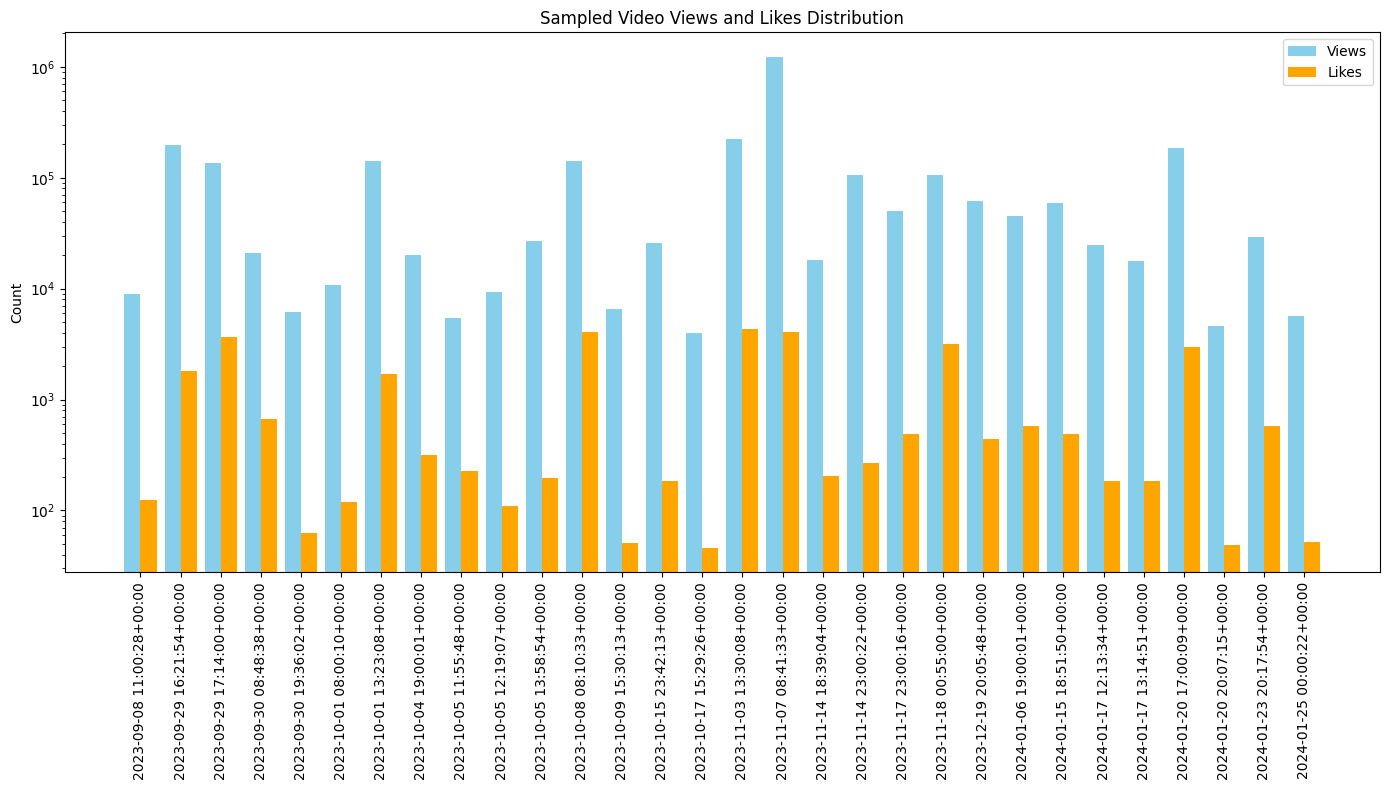

In [547]:
# Convert 'published_date' to datetime format if it's not already
youtube_videos_and_comments['published_date'] = pd.to_datetime(youtube_videos_and_comments['published_date'])
# Assuming 'youtube_videos_and_comments' is your DataFrame
unique_video_data = youtube_videos_and_comments.drop_duplicates(subset=['video_id', 'view_count', 'like_count'])

# Sampling a subset for clarity in visualization
sampled_data = unique_video_data.sample(n=30, random_state=42)
sampled_data = sampled_data.sort_values(by='published_date')
# Setting the positions and width for the bars
positions = list(range(len(sampled_data['video_id'])))
width = 0.4

fig, ax = plt.subplots(figsize=(14, 8))

# Plotting view counts
plt.bar([p - width/2 for p in positions], sampled_data['view_count'], width, color='skyblue', label='Views')

# Plotting like counts
plt.bar([p + width/2 for p in positions], sampled_data['like_count'], width, color='orange', label='Likes')

# Setting the position of the x ticks
ax.set_xticks(positions)
ax.set_xticklabels(sampled_data['published_date'], rotation=90)

ax.set_title('Sampled Video Views and Likes Distribution')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

**Word Cloud & Comment length distribution**

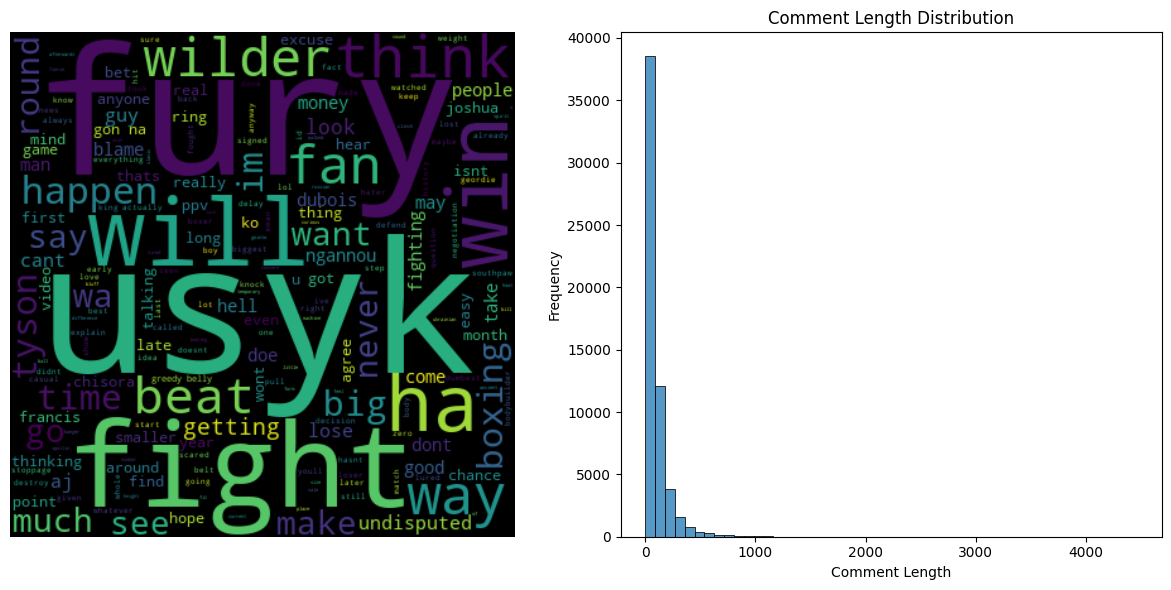

In [520]:
# Word cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
wordcloud = WordCloud(width=400, height=400, max_words=200, background_color='black').generate(" ".join(comments))
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
df = youtube_videos_and_comments.copy()
# Comment length distribution
df['comment_length'] = df['comment'].str.len()

# Histogram for comment length distribution
sns.histplot(df['comment_length'], bins=50, edgecolor='k', ax=ax2)
ax2.set_title('Comment Length Distribution')
ax2.set(xlabel='Comment Length', ylabel='Frequency')

plt.tight_layout()
plt.show()

## 5. Data Preprocessing

- **Duplicate Elimination**: Remove any duplicate entries to ensure data uniqueness.
- **Comment Length Filtering**: Keep only comments shorter than 300 characters to maintain analytical focus.
- **Comment Cleaning**:
  - Normalize text to lowercase for consistency.
  - Remove digits and punctuations to reduce noise.
  - Tokenize comments for individual word analysis.
  - Apply lemmatization to consolidate word variants.
  - Filter out stop words to highlight meaningful content.
- **Non-English Comment Removal**: Exclude comments not in English to streamline the analysis to a single language.
- **Save Preprocessed Dataset**: Save to `data/preprocessed/dp_data.csv`

**Load Full Dataset from Data Collection step**

In [17]:
# path to youtube videos and comments CSV 
youtube_videos_and_comments_path = "data/raw/youtube_videos_comments.csv"

# Load data
full_youtube_data = dl.load_data(youtube_videos_and_comments_path)

### Duplicate Elimination

In [18]:
print('Shape Before duplicate removal:', full_youtube_data.shape)

# Remove duplicates
full_youtube_data = full_youtube_data.drop_duplicates()

# Shape of dataframe after duplicate removal 
print('Shape After duplicate removal:', full_youtube_data.shape)

Shape Before duplicate removal: (57949, 11)
Shape After duplicate removal: (56652, 11)


### Comments Length Filtering

In [19]:
# Create new column with comments length
full_youtube_data['comment_len'] = full_youtube_data['comment'].str.len()

# Remove comments with length > 300
full_youtube_data = full_youtube_data[full_youtube_data['comment_len'] < 300]

# Shape of df after filtering
print('Shape After filtering: ', full_youtube_data.shape)

Shape After filtering:  (53842, 12)


### Comments Cleaning

In [20]:
# Initiase preprocessor
preprocessor = Preprocessor()

# Clean the comments
clean_youtube_data = full_youtube_data.copy()
clean_youtube_data['clean_comment'] = full_youtube_data['comment'].apply(preprocessor.preprocessing)

### Non-English Comments Removal

In [21]:
# Detect language if it is English or Not
clean_youtube_data.loc[:,'is_english'] = clean_youtube_data['clean_comment'].apply(preprocessor.is_english)

# Remove none English comments
clean_youtube_data = clean_youtube_data[clean_youtube_data['is_english']]

# Shape of filtered comments 
print('Shape After Comments removal: ', clean_youtube_data.shape)

Shape After Comments removal:  (42317, 14)


**Save Preprocessed Dataset**

In [22]:
ds.save_to_csv(clean_youtube_data, "data/preprocessed/dp_data.csv")

Data saved to: data/preprocessed/dp_data.csv


## 6. Feature Engineering

- **Engagement Feature Creation**: Calculate an engagement score for each comment using metrics like likes and replies, providing a quantitative measure of user interaction.

- **Engagement-Based Filtering**: Retain comments that fall within the top 25% of engagement scores, ensuring the dataset comprises highly interactive content.

- **Keyword-Based Categorization**: Assign comments to categories based on the presence of specific keywords related to Usyk, Fury, both, or neither. This step is crucial for segmenting the data according to the context of discussion.

- **Visualization**: Display a frequency distribution plot for the initial categorization to understand the comment landscape.

- **Category Filtering**: Focus exclusively on comments mentioning both fighters. This approach is chosen to ensure the BERT model can better generalize across discussions involving multiple entities. By analyzing comments that reference both fighters, the model is encouraged to recognize and learn from the nuances of comparative or relational discourse, enhancing its ability to understand complex interactions between entities within the text.


### Engagement Feature Creation

In [45]:
# Initialize Feature Engineering class
feature_engineering = FeatureEngineering()
# Load preprocessed Dataset 
clean_youtube_data = dl.load_data("data/preprocessed/dp_data.csv")
# Create new feature `engagement` from like_count and comment_count 
clean_youtube_data = feature_engineering.engagement(clean_youtube_data, 'comment_likes', 'total_reply_count')

In [46]:
clean_youtube_data[['comment_likes','total_reply_count','engagement']].describe()

,comment_likes,total_reply_count,engagement
count,42317.000000,42317.000000,42317.000000
mean,7.668384,0.725619,9.394002
std,180.248168,5.465411,183.797391
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,1.000000,0.000000,2.000000
max,24432.000000,443.000000,24876.000000


### Engagement-Based Filtering

In [49]:
# Applying the quantile_threshold function
feature_to_filter = 'engagement'
quantile_value = 0.25 

# Filter values above the 25th percentile
filtered_youtube_data = feature_engineering.quantile_threshold(clean_youtube_data, feature_to_filter, quantile_value)

# Shape
print('Shape Filtered comments by engagement: ', filtered_youtube_data.shape)

Shape Filtered comments by engagement:  (14923, 15)


### Keyword-Based Categorisation

In [53]:
# Create categories for Usyk, Fury, Fury_Usyk or None
categorised_data = feature_engineering.categorize_comments(filtered_youtube_data)

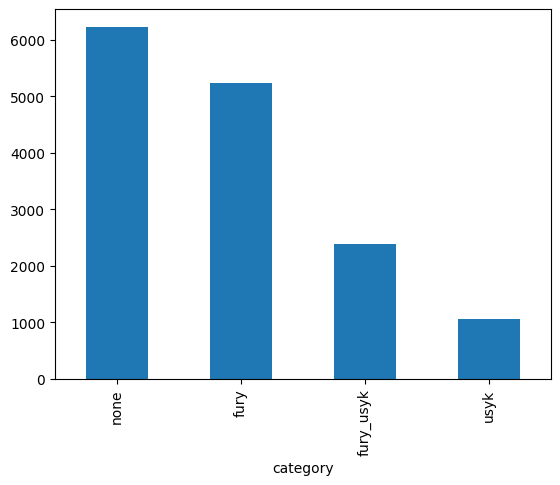

In [54]:
# Plot category distribution
categorised_data['category'].value_counts().plot(kind='bar');

### Category Filtering

Select only `fury_usyk` category

In [55]:
categorised_data = categorised_data[categorised_data['category'] == 'fury_usyk']

# Shape
print('Shape of filtered categories: ', categorised_data.shape)

Shape of filtered categories:  (2390, 16)


### Save Clean, Filtered, Categoriesed data

In [56]:
path_to_processed_data = "data/preprocessed/fe_data.csv"
ds.save_to_csv(categorised_data, path_to_processed_data)

Data saved to: data/preprocessed/fe_data.csv


## 7. Annotation 

### Prompt Engineering (Humman Feedback Annotation)

1. **Start**
   - Initiate the comment annotation process.

2. **Get Batch of Comments**
   - Retrieve a batch of YouTube comments for annotation.

3. **OpenAI Annotation**
   - Annotate comments using OpenAI API with current prompts.

4. **Check for Existing Human Annotations**
   - Verify if there are pre-existing human annotations.
   - If yes, proceed to calculate accuracy.
   - If no, direct to human annotation.

5. **Human Annotation**
   - Manually annotate comments to provide a benchmark.

6. **Calculate Accuracy**
   - Determine the accuracy of OpenAI annotations by comparing them to human annotations.

7. **Review and Adjust**
   - Print out the accuracy results.
   - If accuracy is above 80%, update comment batches for further annotation.
   - If accuracy is below 80%, add a new prompt to refine OpenAI's annotation process.

8. **Decision Point: Continue or Terminate**
   - Decide whether to continue with a new batch of comments.
   - If continuing, update the comment batches.
   - If terminating, end the annotation process.

This workflow ensures a continuous improvement loop for comment annotations by integrating human feedback and systematically refining the prompts used for OpenAI annotation, aiming to enhance overall accuracy.

<img src="HFAnnotation_diagram.png" width="70%">


### Humman Feedback Annotation
**!!! The following workflow is described above!!!**

In [136]:
from src.human_feedback_annotation_openai import HFAnnotator
comments_source = "data/preprocessed/fe_data.csv"
annotations_source = "data/human_feedback_annotations/gold_standard_dataset.csv"
prompt_source = "data/human_feedback_annotations/prompts.csv"
accuracy_source = "data/human_feedback_annotations/acc_score.csv"

annotator = HFAnnotator(comments_source, annotations_source, prompt_source, accuracy_source, 5)

while True:
    # Annotate comments using OpenAI
    openai_annotations = annotator.openai_annotate()
 
    exists = annotator.check_existing_annotations(openai_annotations)
    print(exists)
    if exists == False:
        # If no existing annotation, perform human annotation
        annotation = annotator.human_annotate(openai_annotations)
    
    # Calculate the accuracy of annotations
    accuracy = annotator.calculate_accuracy(openai_annotations)
    print(accuracy)
    annotator.save_accuracy_score(accuracy)
    # If accuracy is not 80%, add a new prompt
    if accuracy < 0.8:
        annotator.add_new_prompt()
    
    # Decide to continue or not based on user input
    continue_annotation = input("Continue with the next batch? (yes/no): ").strip().lower()
    if continue_annotation != 'yes':
        print("Annotation process terminated.")
        break
    
    # Update the comment batches for the next iteration
    annotator.update_comment_batches()


[=================================================>] 100%
True
Comment: I watched a few fights of Usyk and he does get hit more then we like to think when talking about him, the big question is can he breach the distance of Furys long Jab without getting caught or getting cuddled and leand on?
OpenAi sentiments: neutral, neutral
User sentiments: neutral, negative
Batch 40 Accuracy: 0.9
0.9
   batch  prompt_id  accuracy
0     40          5       0.9


Continue with the next batch? (yes/no):  no


Annotation process terminated.


### Annotation Scaling

After achieving satisfactory results in accuracy through prompt engineering and annotation refinement, the annotation scaling process begins. This phase involves scaling up annotation efforts to label the remaining comments efficiently. 

**Implementation**

The implementation of annotation scaling involves looping over the categorized comments using the best prompt identified during the prompt engineering phase. This iterative process utilizes the refined prompt to annotate the comments with higher accuracy, paving the way for machine learning and deep learning model training.


In [162]:
annotator = Annotator("data/human_feedback_annotations/prompts.csv")
clean_data = dl.load_data("data/preprocessed/fe_data.csv")
annotated_data = annotator.annotate_comments(clean_data.loc[110:1000,:], 8)

[=================================================>] 99%

In [166]:
ds.save_to_csv(annotated_data, "data/annotated/full_annnotated_data.csv")

Data saved to: data/annotated/full_annnotated_data.csv


## 8. Secondary Exploratory Data Analysis (EDA)
- **Prompt Engineering**: Accuracy of prompts 
- **Sentiment Distribution of Annotated Comments**: Understand the balance of sentiment labels.
- **Combined Sentiment Distribution**: An overview look how each comment distributes the sentiments in both fighters.
- **WordCloud**: Visualize common words or phrases.
- **Length Distribution Post-Cleaning**: Display a histogram of comment lengths after preprocessing.

### Prompt Engineering Accuracy

- Following the successful milestone of achieving over 80% accuracy in prompt engineering with the ChatGPT model, the annotation scaling phase becomes paramount.

- Visualizing the annotation scaling process involves plotting the distribution of comments labeled with the refined prompts across different batches. This provides valuable insights into the effectiveness and efficiency of the annotation scaling approach.


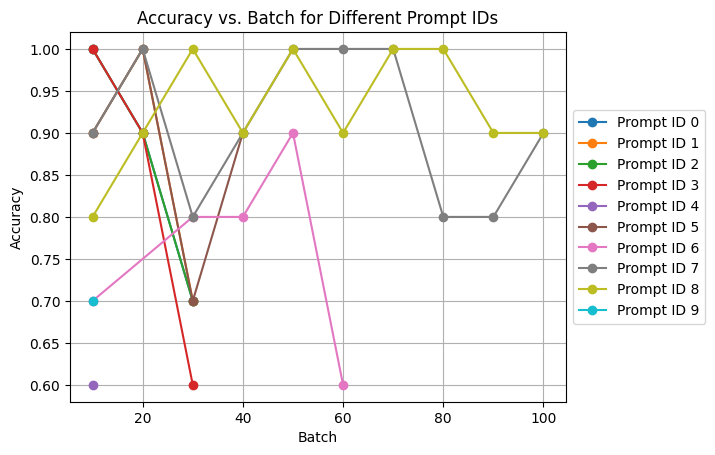

In [142]:
df = pd.read_csv("data/human_feedback_annotations/acc_score.csv")

# Group by prompt_id and plot
for prompt_id, group in df.groupby('prompt_id'):
    plt.plot(group['batch'], group['accuracy'], marker='o', label=f'Prompt ID {prompt_id}')

# Add labels and legend
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch for Different Prompt IDs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Show the plot
plt.show()


### Sentiment Distribution of Annotated Comments
- The sentiment distribution analysis provides valuable insights into the sentiments expressed towards each fighter, Usyk and Fury from the annotated comments from step 6.

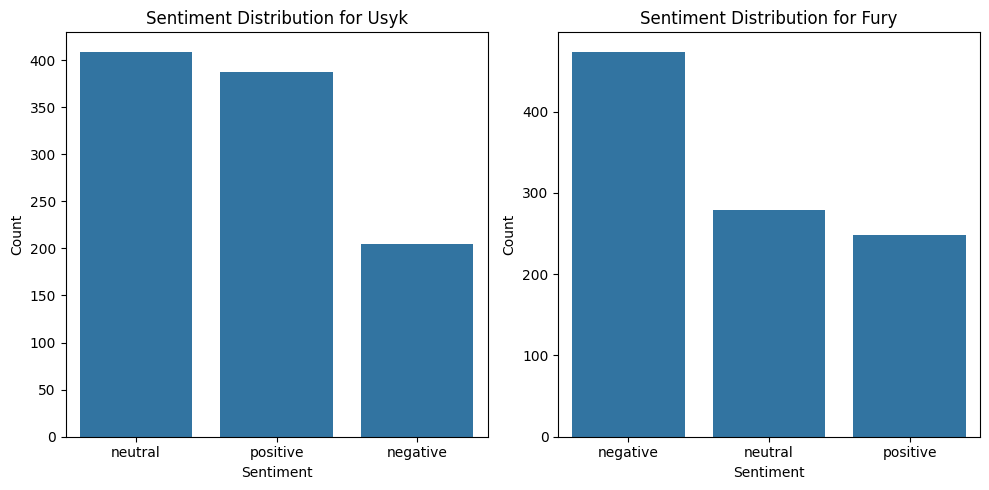

In [168]:
annotated_data = dl.load_data("data/annotated/full_annnotated_data.csv")
usyk_sent = annotated_data['usyk_sentiment'].value_counts(dropna=False)
fury_sent = annotated_data['fury_sentiment'].value_counts(dropna=False)

# Setting up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting for Usyk
sns.barplot(x=usyk_sent.index, y=usyk_sent.values, ax=ax1)
ax1.set_title('Sentiment Distribution for Usyk')
ax1.set_ylabel('Count')
ax1.set_xlabel('Sentiment')

# Plotting for Fury
sns.barplot(x=fury_sent.index, y=fury_sent.values, ax=ax2)
ax2.set_title('Sentiment Distribution for Fury')
ax2.set_ylabel('Count')
ax2.set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

### Combined Sentiment Distribution
- The combined sentiment distribution provides an overview of the sentiments expressed towards both fighters, Usyk and Fury, simultaneously.


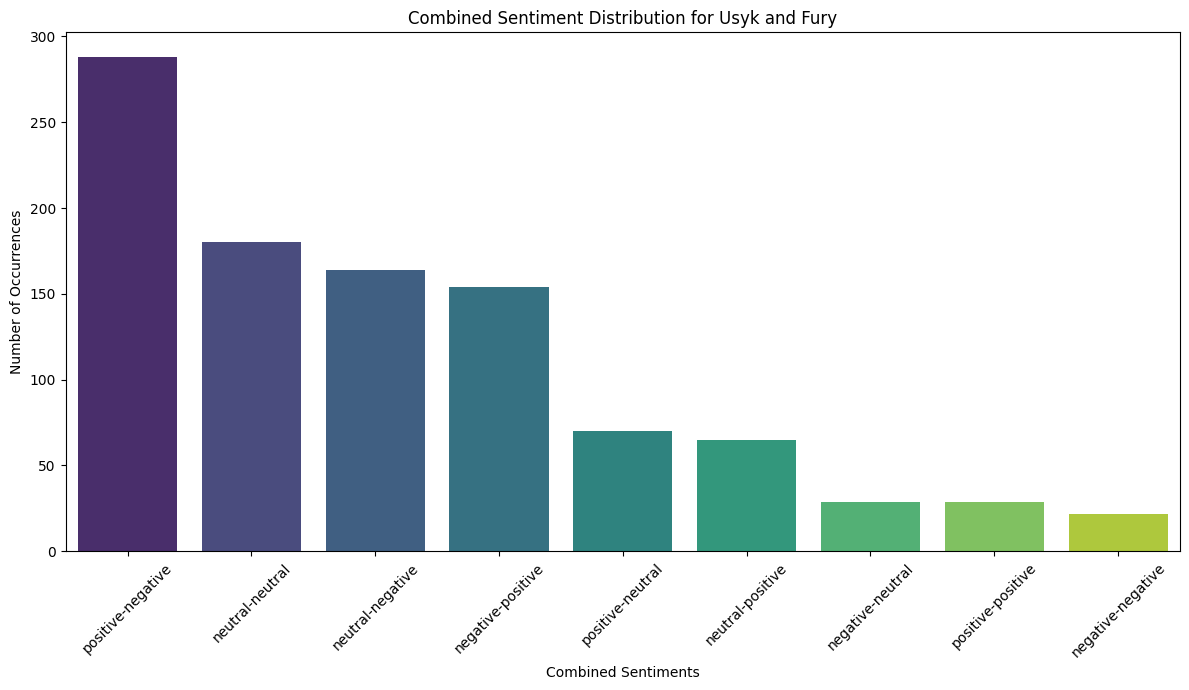

In [169]:
# Combine sentiments
annotated_data['combined_sentiment'] = annotated_data['usyk_sentiment'] +'-'+ annotated_data['fury_sentiment']

# Count the occurrences of each combined sentiment
sentiment_counts = annotated_data['combined_sentiment'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Combined Sentiment Distribution for Usyk and Fury")
plt.ylabel("Number of Occurrences")
plt.xlabel("Combined Sentiments")
# rotate x labels for better readability
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


### WordCloud

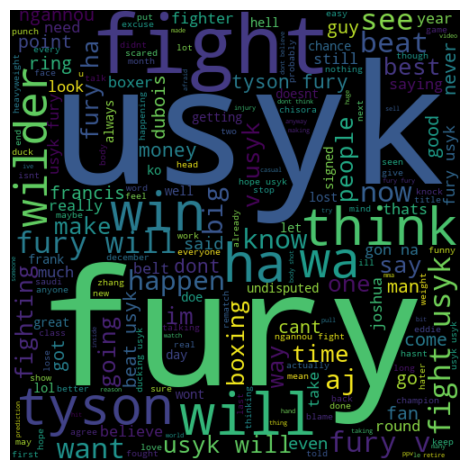

In [172]:
comments = annotated_data['clean_comment']
wordcloud = WordCloud(width=500, height=500, max_words=200).generate(" ".join(comments))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### Length Distribution Post-Cleaning

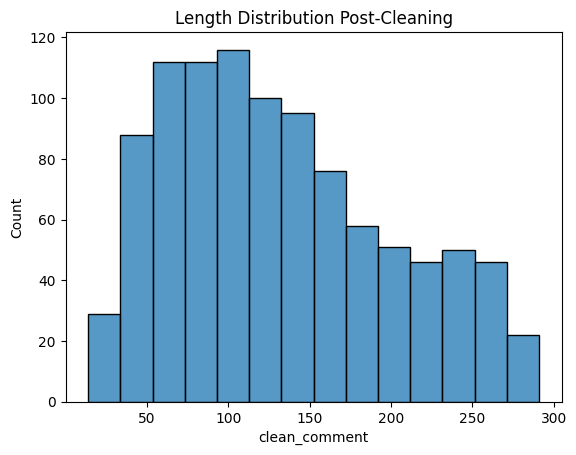

In [173]:
comment_length = annotated_data['clean_comment'].apply(len)
sns.histplot(comment_length)
plt.title("Length Distribution Post-Cleaning")
plt.show()

## 9. Datasets Preparation
- Creating and saving 3 disticts dataset for training.

### Keyword-Based Dataset
- The Keyword-Based Dataset, derived from the initial data collection phase, serves as the foundation for sentiment analysis. This dataset contains comments categorized based on predefined keywords related to the boxing match, capturing a broad spectrum of sentiments expressed by users.


In [221]:
keyword_based_dataset = annotated_data[["clean_comment", "usyk_sentiment", "fury_sentiment"]].copy()
ds.save_to_csv(keyword_based_dataset, "data/datasets/kwb.csv")

Data saved to: data/datasets/kwb.csv


### Balanced Dataset
- To address class imbalances and ensure robust model training, a Balanced Dataset is created using downsampling techniques. This dataset comprises an equal distribution of comments categorized into neutral, positive, and negative sentiments, mitigating biases towards dominant sentiment classes.

In [223]:
# Downsampling for Usyk sentiment
usyk_positive_downsampled = annotated_data[annotated_data['usyk_sentiment'] == 'positive'].sample(n=200, random_state=42)
usyk_neutral_downsampled = annotated_data[annotated_data['usyk_sentiment'] == 'neutral'].sample(n=200, random_state=42)
usyk_negative = annotated_data[annotated_data['usyk_sentiment'] == 'negative']

# Combine the downsampled classes into a new balanced DataFrame for Usyk
df_usyk_balanced = pd.concat([usyk_positive_downsampled, usyk_neutral_downsampled, usyk_negative])

# Downsampling for Fury sentiment
fury_negative_downsampled = annotated_data[annotated_data['fury_sentiment'] == 'negative'].sample(n=200, random_state=42)
fury_neutral_downsampled = annotated_data[annotated_data['fury_sentiment'] == 'neutral'].sample(n=200, random_state=42)
fury_positive = annotated_data[annotated_data['fury_sentiment'] == 'positive']

# Combine the downsampled classes into a new balanced DataFrame for Fury
df_fury_balanced = pd.concat([fury_negative_downsampled, fury_neutral_downsampled, fury_positive])

# Combine final df
balanced_dataset = pd.concat([df_usyk_balanced, df_fury_balanced])

balanced_dataset = balanced_dataset.drop_duplicates()

# save dataset
ds.save_to_csv(balanced_dataset, "data/datasets/balanced.csv")

Data saved to: data/datasets/balanced.csv


### Auxiliary Dataset

- The Auxiliary Dataset enhances the training process by augmenting each comment with an auxiliary sentence tailored to each fighter entity. These auxiliary sentences serve as context-enriching prompts, aiding models like BERT in generalizing sentiment analysis across different entities. As a result, the dataset size doubles, with each comment paired with a distinct auxiliary sentence for Fighter A or Fighter B.

In [753]:
# Function to create an auxiliary sentence based on sentiment
def create_auxiliary_sentence(fighter_name):
    return f"is the sentiment in favour or support of {fighter_name}?"

# List to store new rows for the new DataFrame
new_rows = []

for index, row in annotated_data.iterrows():
    comment = row['clean_comment']
    usyk_sentiment = row['usyk_sentiment']
    fury_sentiment = row['fury_sentiment']

    # Create auxiliary sentences for Usyk and Fury
    usyk_aux = create_auxiliary_sentence('Oleksandr Usyk')
    fury_aux = create_auxiliary_sentence('Tyson Fury')

    # Append auxiliary sentences to the comment and create the target label
    if usyk_aux and fury_aux:
        new_rows.append({'clean_comment': comment + ' [SEP] ' + usyk_aux +' '+ fury_aux, 'usyk_sentiment': usyk_sentiment, 'fury_sentiment': fury_sentiment})


# Create a new DataFrame from the new rows
aux_dataset = pd.DataFrame(new_rows, columns=['clean_comment', 'usyk_sentiment', 'fury_sentiment'])

# Save Dataset
ds.save_to_csv(aux_dataset,  "data/datasets/aux_dataset.csv")

File data/datasets/aux_dataset.csv already exists! Overwrite (O), Append (A), Cancel (C)?  O


Data saved to: data/datasets/aux_dataset.csv


## 10. Baseline Model Evaluation

In the baseline evaluation section, we train and assess three distinct models, each employing different settings and tokenization techniques to establish a foundational understanding of our sentiment analysis capabilities. The models include:

1. **Bag of Words (BoW) with Multinomial Naive Bayes (MB):** Utilizes a simple yet effective BoW approach for feature extraction combined with the probabilistic learning of Multinomial NB, ideal for handling discrete data like word counts.

2. **Logistic Regression (LR) with TF-IDF with N-grams (1,3):** Employs Term Frequency-Inverse Document Frequency (TF-IDF) for a more nuanced feature representation, enhancing the Logistic Regression model's ability to discern the linear relationships between features and sentiment classes.

3. **Support Vector Classifier (SVC) with TF-IDF with N-grams (1,3):** Leverages the power of Support Vector Machines along with n-gram (ranging from unigrams to trigrams) tokenization, providing a robust framework for capturing contextual information and complex patterns within the text.

Each model's performance is evaluated based on standard metrics to establish a baseline for further experimental comparisons.

### Bag of Words (BoW) with Multinomial Naive Bayes (MB)

In [14]:
def baseline_model(X, y):
    print("-------MB MODEL-------")
    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature extraction
    count_vectorizer = CountVectorizer()
    X_train_counts = count_vectorizer.fit_transform(X_train)
    X_test_counts = count_vectorizer.transform(X_test)
    
    # Train the model
    model = MultinomialNB()
    model.fit(X_train_counts, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_counts)
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_counts, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    # Extracting F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'MB Accuracy: {mean_cv_score}')
    print(f'MB F1 Score: {f1}')

    return mean_cv_score, f1


### Logistic Regression (LR) TF-IDF with N-grams (1,3)

In [15]:
def lr_model(X, y): 
    print('------LR MODEL-------')
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Feature extraction
    tfidf_vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,3))
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    # Model training
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    
    # Model evaluation on test set
    y_pred = model.predict(X_test_tfidf)
    # accuracy = accuracy_score(y_test, y_pred)

     # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    # Extracting F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'LR Accuracy: {mean_cv_score}')
    print(f'LR F1 Score: {f1}')


    return mean_cv_score, f1

### Support Vector Classifier (SVC) TF-IDF with N-grams (1,3)

In [16]:
def svc_model(X, y):
    print('------SVC MODEL-------')
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Feature extraction
    tfidf_vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,3))
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    # Model training
    model = SVC(kernel='linear')
    model.fit(X_train_tfidf, y_train)

    # Model evaluation on validation set
    y_pred = model.predict(X_test_tfidf)
    
    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)

    print(f'SVC Accuracy: {mean_cv_score}')
    print(f'SVC F1 Score: {f1}')

    return mean_cv_score, f1



### Evaluate Machine Learning Models
The `evaluate_models` function assesses ML models on different datasets, calculating accuracy and another metric for sentiments towards Usyk and Fury. It iterates through models and datasets, applying each model to the dataset's comments and sentiments, then logs the performance results. This structured evaluation provides insights into each model's effectiveness across varied data contexts, aiding in the selection of the most suitable model for sentiment analysis tasks in the domain of combat sports discussions.

In [24]:
def evaluate_models(model_name, models, datasets):
    results = {key: {"Usyk": [], "Fury": []} for key in datasets.keys()}
    for model_name, model_function in models.items():
        for dataset_name, dataset in datasets.items():
            X = dataset['clean_comment']
            y_usyk = dataset['fury_sentiment']
            y_fury = dataset['usyk_sentiment']
    
            for sentiment, y in [("Usyk", y_usyk), ("Fury", y_fury)]:
                print(f" \nModel: {model_name}")
                print(f"Dataset: {dataset_name} | Entity: {sentiment}")
                accuracy, metric = model_function(X, y)
                results[dataset_name][sentiment].append(accuracy)
                results[dataset_name][sentiment].append(metric)
    
    return results

# Example usage:
keyword_based_dataset = dl.load_data("data/datasets/kwb.csv")
balanced_dataset = dl.load_data("data/datasets/balanced.csv")
aux_dataset = dl.load_data("data/datasets/aux_dataset.csv")
datasets = {"KWB": keyword_based_dataset, "Balanced": balanced_dataset, "AUX": aux_dataset}
models = {"MB + BoW":baseline_model,"LR + Tf + N-gram":lr_model,"SVC + Tf + N-gram":svc_model }
baseline_results = evaluate_models("MB + BoW", models, datasets)

 
Model: MB + BoW
Dataset: KWB | Entity: Usyk
-------MB MODEL-------
MB Accuracy: 0.5762499999999999
MB F1 Score: 0.5663301309544233
 
Model: MB + BoW
Dataset: KWB | Entity: Fury
-------MB MODEL-------
MB Accuracy: 0.65125
MB F1 Score: 0.6483231027069213
 
Model: MB + BoW
Dataset: Balanced | Entity: Usyk
-------MB MODEL-------
MB Accuracy: 0.5589428115743905
MB F1 Score: 0.5737090410668444
 
Model: MB + BoW
Dataset: Balanced | Entity: Fury
-------MB MODEL-------
MB Accuracy: 0.5996696286169969
MB F1 Score: 0.6299180437806026
 
Model: MB + BoW
Dataset: AUX | Entity: Usyk
-------MB MODEL-------
MB Accuracy: 0.5775
MB F1 Score: 0.5033044892270165
 
Model: MB + BoW
Dataset: AUX | Entity: Fury
-------MB MODEL-------
MB Accuracy: 0.63125
MB F1 Score: 0.6332150085382818
 
Model: LR + Tf + N-gram
Dataset: KWB | Entity: Usyk
------LR MODEL-------
LR Accuracy: 0.59
LR F1 Score: 0.6262982955937397
 
Model: LR + Tf + N-gram
Dataset: KWB | Entity: Fury
------LR MODEL-------
LR Accuracy: 0.647500000

In [31]:
bl_results_df = pd.DataFrame(baseline_results)
ds.save_to_csv(bl_results_df, "data/results/baseline_results.csv")

Data saved to: data/results/baseline_results.csv


## 11. BERT (Bidirectional Encoder Representations from Transformers) Model

### Data Preprocessing and Splitting

This code segment performs the following tasks:

1. **Label Encoding**:
   - It initializes two `LabelEncoder` objects, `label_encoder_fury` and `label_encoder_usyk`, to encode the Fury and Usyk sentiments, respectively.
   - Fury sentiments are encoded and stored in a new column named `'fury_label'` in the DataFrame.
   - Usyk sentiments are encoded and stored in a new column named `'usyk_label'` in the DataFrame.

2. **Dataset Splitting**:
   - The DataFrame, `keyword_based_dataset`, is copied to avoid modifying the original data.
   - The dataset is split into training and validation sets using `train_test_split` from scikit-learn.
   - The training set, `train_df`, contains 90% of the data, and the validation set, `val_df`, contains the remaining 10%.



In [767]:
# Initialize label encoders for Fury and Usyk sentiments
label_encoder_fury = LabelEncoder()  # This label encoder will encode Fury sentiments
label_encoder_usyk = LabelEncoder()  # This label encoder will encode Usyk sentiments

# Create a copy of the original dataset
df = aux_dataset.copy()

# Encode Fury sentiments and create a new column 'fury_label' in the DataFrame
df['fury_label'] = label_encoder_fury.fit_transform(df['fury_sentiment'])

# Encode Usyk sentiments and create a new column 'usyk_label' in the DataFrame
df['usyk_label'] = label_encoder_usyk.fit_transform(df['usyk_sentiment'])

# Split the DataFrame into training and validation sets with a 90:10 ratio
train_df, val_df = train_test_split(df, test_size=0.1)


### Custom Sentiment Dataset Class

- **Class Definition**:
  - The class `SentimentDataset` inherits from the `torch.utils.data.Dataset` class.
  - It contains a constructor (`__init__`), a method to get the length of the dataset (`__len__`), and a method to get a specific item from the dataset (`__getitem__`).

- **Constructor**:
  - The constructor initializes the dataset with comments, Fury labels, Usyk labels, a tokenizer, and the maximum sequence length.

- **`__len__` Method**:
  - This method returns the length of the dataset, which is the number of comments in the dataset.

- **`__getitem__` Method**:
  - This method retrieves a specific item from the dataset.
  - It encodes the comment using the provided tokenizer, ensuring that the input is formatted correctly for model input.
  - It returns a dictionary containing the encoded input IDs, attention mask, Fury labels, and Usyk labels for the specified item.


In [768]:
# Define a custom dataset class for sentiment analysis
class SentimentDataset(Dataset):
    # Constructor to initialize the dataset
    def __init__(self, comments, fury_labels, usyk_labels, tokenizer, max_len):
        self.comments = comments  # List of comments
        self.fury_labels = fury_labels  # Fury sentiment labels
        self.usyk_labels = usyk_labels  # Usyk sentiment labels
        self.tokenizer = tokenizer  # Tokenizer for text encoding
        self.max_len = max_len  # Maximum sequence length
    
    # Method to get the length of the dataset
    def __len__(self):
        return len(self.comments)
    
    # Method to get a specific item from the dataset
    def __getitem__(self, item):
        # Retrieve the comment, Fury label, and Usyk label for the specified item
        comment = str(self.comments[item])
        fury_label = self.fury_labels[item]
        usyk_label = self.usyk_labels[item]
        
        # Encode the comment using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Return the encoded inputs and labels as a dictionary
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'fury_labels': torch.tensor(fury_label, dtype=torch.long),
            'usyk_labels': torch.tensor(usyk_label, dtype=torch.long)
        }


### Data Loader Creation

The provided code defines a function `create_data_loader` to generate data loaders for the training and validation sets. Here's what each part of the code does:

- **Tokenizer Initialization**:
  - The BERT tokenizer is initialized using `BertTokenizer.from_pretrained('bert-base-uncased')`.

- **Constants Definition**:
  - `MAX_LEN` is set to 100, representing the maximum sequence length for tokenization.
  - `BATCH_SIZE` is set to 32, specifying the batch size for the data loader.

- **Data Loader Creation Function**:
  - The function `create_data_loader` takes a DataFrame (`df`), tokenizer, maximum sequence length (`max_len`), and batch size (`batch_size`) as input.
  - It creates a `SentimentDataset` instance (`ds`) using the provided DataFrame and parameters.
  - It returns a DataLoader for the dataset with the specified batch size, ensuring efficient loading of data during training and validation.

- **Data Loader Instantiation**:
  - Data loaders for the training and validation sets (`train_data_loader` and `val_data_loader`) are created using the `create_data_loader` function and the respective DataFrames (`train_df` and `val_df`), tokenizer, maximum sequence length, and batch size.


In [769]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Maximum sequence length for tokenization
MAX_LEN = 100

# Batch size for data loader
BATCH_SIZE = 32

# Function to create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    # Create a SentimentDataset instance using the provided DataFrame and parameters
    ds = SentimentDataset(
        comments=df.clean_comment.to_numpy(),  # Extract comments from the DataFrame
        fury_labels=df.fury_label.to_numpy(),  # Extract Fury labels from the DataFrame
        usyk_labels=df.usyk_label.to_numpy(),  # Extract Usyk labels from the DataFrame
        tokenizer=tokenizer,  # Use the provided tokenizer
        max_len=max_len  # Use the provided maximum sequence length
    )
    
    # Create a DataLoader for the dataset with the specified batch size
    return DataLoader(ds, batch_size=batch_size, num_workers=0)  # Set num_workers to 0 for Jupyter

# Create data loaders for the training and validation sets
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

### Sentiment Classifier Neural Network

The provided code defines a sentiment classifier neural network using the BERT model for two different sentiment analysis tasks related to "Fury" and "Usyk". Here's a breakdown of the code:

- **Class Definition**:
  - The class `SentimentClassifier` inherits from `nn.Module`, the base class for all neural network modules in PyTorch.

- **Constructor**:
  - The constructor initializes the model.
  - It loads the pre-trained BERT model (`bert`) using `BertModel.from_pretrained('bert-base-uncased')`.
  - A dropout layer (`drop`) with a dropout probability of 0.3 is added to prevent overfitting.
  - Two output layers (`out_fury` and `out_usyk`) are defined for predicting Fury and Usyk sentiments, respectively. The number of output classes for each sentiment task is specified by `n_classes_fury` and `n_classes_usyk`.

- **Forward Method**:
  - The `forward` method defines the forward pass through the network.
  - The input is passed through the BERT model to obtain the outputs.
  - The pooled output (CLS token representation) is extracted from the BERT outputs.
  - Dropout is applied to the pooled output for regularization.
  - The logits for both Fury and Usyk sentiments are computed using the output of the dropout layer and the respective output layers.
  - The logits are returned as the output of the forward pass.


In [770]:
# Define the sentiment classifier neural network class
class SentimentClassifier(nn.Module):
    # Constructor to initialize the model
    def __init__(self, n_classes_fury, n_classes_usyk):
        super(SentimentClassifier, self).__init__()
        
        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Dropout layer to prevent overfitting
        self.drop = nn.Dropout(p=0.3)
        
        # Output layer for Fury sentiment classification
        self.out_fury = nn.Linear(self.bert.config.hidden_size, n_classes_fury)
        
        # Output layer for Usyk sentiment classification
        self.out_usyk = nn.Linear(self.bert.config.hidden_size, n_classes_usyk)
    
    # Forward pass through the network
    def forward(self, input_ids, attention_mask):
        # Pass the input through the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the pooled output (CLS token representation)
        pooled_output = outputs.pooler_output
        
        # Apply dropout for regularization
        output = self.drop(pooled_output)
        
        # Predict Fury sentiment
        fury_logits = self.out_fury(output)
        
        # Predict Usyk sentiment
        usyk_logits = self.out_usyk(output)
        
        # Return the logits for both Fury and Usyk sentiment
        return fury_logits, usyk_logits



### Training Epoch Function

The provided function, `train_epoch`, trains a model for one epoch (a single pass through the entire training dataset) and returns the accuracy and average loss.

- **Function Signature**:
  - `train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples)`

- **Parameters**:
  - `model`: The neural network model to be trained.
  - `data_loader`: The data loader providing batches of training data.
  - `loss_fn`: The loss function used to compute the loss.
  - `optimizer`: The optimizer used to update the model parameters.
  - `device`: The device (CPU or GPU) on which the computation will be performed.
  - `n_examples`: The total number of examples in the training dataset.

- **Function Steps**:
  1. **Set Model to Training Mode**:
     - The function sets the model to training mode using `model.train()`.
  2. **Initialization**:
     - Lists are initialized to store losses and correct predictions for Fury and Usyk sentiment tasks.
  3. **Iteration over Data Loader**:
     - The function iterates over batches of data provided by the data loader.
  4. **Forward Pass and Loss Computation**:
     - The input data is passed through the model to compute logits.
     - Losses are computed for both Fury and Usyk sentiment tasks using the provided loss function.
  5. **Backpropagation and Parameter Update**:
     - Gradients are zeroed, backpropagation is performed, and model parameters are updated using the provided optimizer.
  6. **Accuracy Computation**:
     - Correct predictions are counted for both sentiment tasks.
     - Accuracy is computed for each sentiment task.
  7. **Average Loss Calculation**:
     - The average loss over the epoch is computed.
  8. **Return Values**:
     - The function returns the accuracy for Fury and Usyk sentiment tasks, along with the average loss.


In [771]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    # Set the model to training mode
    model.train()
    
    # Initialize lists to store losses and correct predictions for each sentiment task
    losses = []
    correct_predictions_fury = 0
    correct_predictions_usyk = 0

    # Iterate over batches of data in the data loader
    for d in data_loader:
        # Move input data and labels to the appropriate device (GPU or CPU)
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        fury_labels = d['fury_labels'].to(device)
        usyk_labels = d['usyk_labels'].to(device)

        # Forward pass through the model to get logits
        fury_logits, usyk_logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute the loss for each sentiment task
        loss_fury = loss_fn(fury_logits, fury_labels)
        loss_usyk = loss_fn(usyk_logits, usyk_labels)
        
        # Total loss is the sum of losses for both sentiment tasks
        total_loss = loss_fury + loss_usyk
        
        # Append the total loss to the list of losses
        losses.append(total_loss.item())

        # Zero the gradients, perform backpropagation, and update model parameters
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Compute the number of correct predictions for each sentiment task
        _, preds_fury = torch.max(fury_logits, dim=1)
        _, preds_usyk = torch.max(usyk_logits, dim=1)

        correct_predictions_fury += torch.sum(preds_fury == fury_labels)
        correct_predictions_usyk += torch.sum(preds_usyk == usyk_labels)

    # Calculate accuracy for each sentiment task and the average loss
    accuracy_fury = correct_predictions_fury.double() / n_examples
    accuracy_usyk = correct_predictions_usyk.double() / n_examples
    average_loss = np.mean(losses)
    
    return accuracy_fury, accuracy_usyk, average_loss



### Evaluation Function for the Model

The provided function, `eval_model`, evaluates a trained model on a validation or test dataset and returns the accuracy and average loss.

- **Function Signature**:
  - `eval_model(model, data_loader, device, n_examples, loss_fn)`

- **Parameters**:
  - `model`: The trained neural network model to be evaluated.
  - `data_loader`: The data loader providing batches of validation or test data.
  - `device`: The device (CPU or GPU) on which the computation will be performed.
  - `n_examples`: The total number of examples in the validation or test dataset.
  - `loss_fn`: The loss function used to compute the loss.

- **Function Steps**:
  1. **Set Model to Evaluation Mode**:
     - The function sets the model to evaluation mode using `model.eval()`.
  2. **Initialization**:
     - Total loss and correct predictions are initialized to zero.
  3. **Evaluation Loop**:
     - The function iterates over batches of data provided by the data loader.
  4. **Forward Pass and Loss Computation**:
     - The input data is passed through the model to compute logits.
     - Losses are computed for both Fury and Usyk sentiment tasks using the provided loss function.
     - The average loss for the batch is calculated.
  5. **Accuracy Computation**:
     - Correct predictions are counted for both Fury and Usyk sentiment tasks.
     - Accuracy is computed for each sentiment task.
  6. **Average Loss Calculation**:
     - The average loss over all batches is computed.
  7. **Return Values**:
     - The function returns the accuracy for Fury and Usyk sentiment tasks, along with the average loss.


In [772]:
def eval_model(model, data_loader, device, n_examples, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to store total loss and correct predictions for each sentiment task
    total_loss = 0
    correct_predictions_fury = 0
    correct_predictions_usyk = 0
    
    # Initialize lists to store predictions and labels for F1 score calculation
    all_preds_fury = []
    all_labels_fury = []
    all_preds_usyk = []
    all_labels_usyk = []

    # Disable gradient tracking since no gradients are needed during evaluation
    with torch.no_grad():
        # Iterate over batches of data in the data loader
        for d in data_loader:
            # Move input data and labels to the appropriate device (GPU or CPU)
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            fury_labels = d['fury_labels'].to(device)
            usyk_labels = d['usyk_labels'].to(device)

            # Forward pass through the model to get logits
            fury_logits, usyk_logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute the loss for each sentiment task
            loss_fury = loss_fn(fury_logits, fury_labels)
            loss_usyk = loss_fn(usyk_logits, usyk_labels)
            
            # Compute the average loss for the batch and add it to the total loss
            total_loss += (loss_fury.item() + loss_usyk.item()) / 2  # Average loss for the batch

            # Compute the number of correct predictions for each sentiment task
            _, preds_fury = torch.max(fury_logits, dim=1)
            _, preds_usyk = torch.max(usyk_logits, dim=1)

            correct_predictions_fury += torch.sum(preds_fury == fury_labels)
            correct_predictions_usyk += torch.sum(preds_usyk == usyk_labels)
            
            # Append predictions and labels for F1 score calculation
            all_preds_fury.extend(preds_fury.tolist())
            all_labels_fury.extend(fury_labels.tolist())
            all_preds_usyk.extend(preds_usyk.tolist())
            all_labels_usyk.extend(usyk_labels.tolist())

    # Calculate the average loss over all batches
    avg_loss = total_loss / len(data_loader)

    # Compute the accuracy for each sentiment task
    accuracy_fury = correct_predictions_fury.double() / n_examples
    accuracy_usyk = correct_predictions_usyk.double() / n_examples
    
    # Compute F1 scores for each entity
    f1_score_fury = f1_score(all_labels_fury, all_preds_fury, average='weighted')
    f1_score_usyk = f1_score(all_labels_usyk, all_preds_usyk, average='weighted')
    
    return accuracy_fury, accuracy_usyk, f1_score_fury, f1_score_usyk, avg_loss


### Model Training and Evaluation

This code segment trains and evaluates a sentiment classifier model for a specified number of epochs. Below is an explanation of what each part of the code does:

- **Device Selection**:
  - It checks if a GPU is available and assigns the appropriate device for computation. If a GPU is not available, it defaults to using the CPU.

- **Model Instantiation and Device Assignment**:
  - The sentiment classifier model is instantiated, and it's moved to the selected device (GPU or CPU) for training and evaluation.

- **Number of Epochs**:
  - The number of epochs for training is set to 8.

- **Optimizer Definition**:
  - AdamW optimizer is defined with a learning rate of 2e-5 and correct_bias set to False.

- **Learning Rate Scheduler**:
  - A scheduler is set up using a linear schedule with warm-up. This scheduler adjusts the learning rate during training.

- **Loss Function**:
  - Cross-Entropy Loss function is defined for optimization. It's moved to the selected device for computation.

- **Metric Lists Initialization**:
  - Lists are initialized to store training metrics such as losses and accuracies for both Fury and Usyk sentiment tasks.

- **Validation Metric Lists (if applicable)**:
  - Similar lists are initialized to store validation metrics if a separate validation dataset is available.

- **Training Loop**:
  - The code iterates over each epoch, performing the following steps:
    - Trains the model for one epoch using the training data loader.
    - Collects training metrics such as loss and accuracy for both Fury and Usyk sentiment tasks.
    - Evaluates the model on the validation set (if available) and collects validation metrics.
    - Prints training and validation metrics for each epoch.



In [773]:
# Determine the device to use for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the sentiment classifier model
model = SentimentClassifier(len(label_encoder_fury.classes_), len(label_encoder_usyk.classes_))

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Set the number of epochs
EPOCHS = 10

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader) * EPOCHS)

# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Initialize lists to store training metrics
train_losses = []
train_accuracies_fury = []
train_accuracies_usyk = []

# Initialize lists to store validation metrics (if applicable)
val_losses = []
val_accuracies_fury = []
val_accuracies_usyk = []
val_f_fury = []
val_f_usyk = []

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    
    # Train the model for one epoch and get training metrics
    train_acc_fury, train_acc_usyk, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, len(train_df))
    
    # Append training metrics to the lists
    train_losses.append(train_loss)
    train_accuracies_fury.append(train_acc_fury)
    train_accuracies_usyk.append(train_acc_usyk)
    
    # Evaluate the model on the validation set and get validation metrics (if applicable)
    # val_acc_fury, val_acc_usyk, val_loss = eval_model(model, val_data_loader, device, len(val_df), loss_fn)
    val_acc_fury, val_acc_usyk, f1_score_fury, f1_score_usyk, val_loss = eval_model(model, val_data_loader, device, len(val_df), loss_fn)
    # Append validation metrics to the lists (if applicable)
    val_losses.append(val_loss)
    val_accuracies_fury.append(val_acc_fury)
    val_accuracies_usyk.append(val_acc_usyk)
    val_f_fury.append(f1_score_fury)
    val_f_usyk.append(f1_score_usyk)    
    
    # Print training and validation metrics for the current epoch
    print(f'Train Loss: {train_loss} Train Accuracy Fury: {train_acc_fury} Train Accuracy Usyk: {train_acc_usyk}')
    print(f'Val Loss: {val_loss} Val Accuracy Fury: {val_acc_fury} | F-1 Score: {f1_score_fury} | Val Accuracy Usyk: {val_acc_usyk} | F-1 Score: {f1_score_usyk}')



Epoch 1/10
Train Loss: 2.1160054001314887 Train Accuracy Fury: 0.4855555555555556 Train Accuracy Usyk: 0.4411111111111111
Val Loss: 1.0111513584852219 Val Accuracy Fury: 0.4752475247524752 | F-1 Score: 0.4251128125725055 | Val Accuracy Usyk: 0.5247524752475248 | F-1 Score: 0.43784101680608317
Epoch 2/10
Train Loss: 1.9701034734989036 Train Accuracy Fury: 0.4988888888888889 Train Accuracy Usyk: 0.5388888888888889
Val Loss: 0.8733155205845833 Val Accuracy Fury: 0.5346534653465347 | F-1 Score: 0.4594911104013627 | Val Accuracy Usyk: 0.693069306930693 | F-1 Score: 0.6425091488740711
Epoch 3/10
Train Loss: 1.5240656671852901 Train Accuracy Fury: 0.6444444444444445 Train Accuracy Usyk: 0.7088888888888889
Val Loss: 0.9819669127464294 Val Accuracy Fury: 0.43564356435643564 | F-1 Score: 0.447841366129764 | Val Accuracy Usyk: 0.6138613861386139 | F-1 Score: 0.6417394680644535
Epoch 4/10
Train Loss: 1.119600932659774 Train Accuracy Fury: 0.7322222222222222 Train Accuracy Usyk: 0.8344444444444444


### Consolidating BERT Model Metrics

The script compiles a DataFrame `bert_results` with key performance metrics from BERT model evaluation on each dataset. It includes training loss, validation loss, training and validation accuracies, and F-scores for both Usyk and Fury sentiments. Post-processing converts Series objects to scalar values for CSV export. The processed data is then saved for further analysis.

In [1009]:
bert_results = (pd.DataFrame({"dataset":"AUX",
                              "train loss":train_losses, 
                              "val Loss": val_losses, 
                              "usyk train acc": train_accuracies_usyk,
                              "fury train acc": train_accuracies_fury,
                              "usyk val acc": val_accuracies_usyk, 
                              "fury val acc": val_accuracies_fury,
                              "usyk f-score":val_f_usyk,                            
                              "fury f-score":val_f_fury,
                             }))
bert_results['usyk val acc'] = bert_results['usyk val acc'].apply(lambda x: x.item())
bert_results['fury val acc'] = bert_results['fury val acc'].apply(lambda x: x.item())
bert_results['usyk train acc'] = bert_results['usyk train acc'].apply(lambda x: x.item())
bert_results['fury train acc'] = bert_results['fury train acc'].apply(lambda x: x.item())
ds.save_to_csv(bert_results, "data/results/aux_results.csv")

File data/results/aux_results.csv already exists! Overwrite (O), Append (A), Cancel (C)?  c


Save operation cancelled.


### Extracting Optimal BERT Model Performance
The `bert_best_results` function evaluates BERT model performance on various datasets by identifying the epoch with the highest combined validation accuracy for Usyk and Fury sentiments. It stores these peak metrics within a given structure for analysis.

In [27]:
datasets = ["KWB","Balanced","AUX"]

def bert_best_results(datasets,arr2d):
    best_results = {}

    for d in datasets:
        data = pd.read_csv(f"data/results/{d.lower()}_results.csv")
        data['combine acc'] = (data['usyk val acc'] + data['fury val acc']) / 2        
        max_index = data['combine acc'].idxmax()
        usyk_val_acc_at_max = data.loc[max_index, 'usyk val acc']
        usyk_f_at_max = data.loc[max_index, 'usyk f-score']
        fury_val_acc_at_max = data.loc[max_index, 'fury val acc']
        fury_f_at_max = data.loc[max_index, 'fury f-score']
        
        arr2d[d]["Usyk"].append(usyk_val_acc_at_max)
        arr2d[d]["Usyk"].append(usyk_f_at_max)
        arr2d[d]["Fury"].append(fury_val_acc_at_max)
        arr2d[d]["Fury"].append(fury_f_at_max)       

    return arr2d
all_results = bert_best_results(datasets,baseline_results)    


### Visualising Model Performance Across Datasets

The provided code dynamically generates a series of visualizations to evaluate the performance of a sentiment analysis model across three distinct datasets: KWB, Balanced, and AUX. Each figure comprises three subplots:

1. **Training and Validation Loss**: The first subplot details the loss during training against the epochs, offering insights into the model's learning progress and convergence behavior.

2. **Accuracy for Fury**: The second subplot tracks the training and validation accuracy for sentiment related to Fury, revealing the model's effectiveness in capturing sentiments associated with this fighter.

3. **Accuracy for Usyk**: The third subplot similarly traces the accuracy for Usyk sentiments, contrasting its predictive performance with that of Fury sentiments.


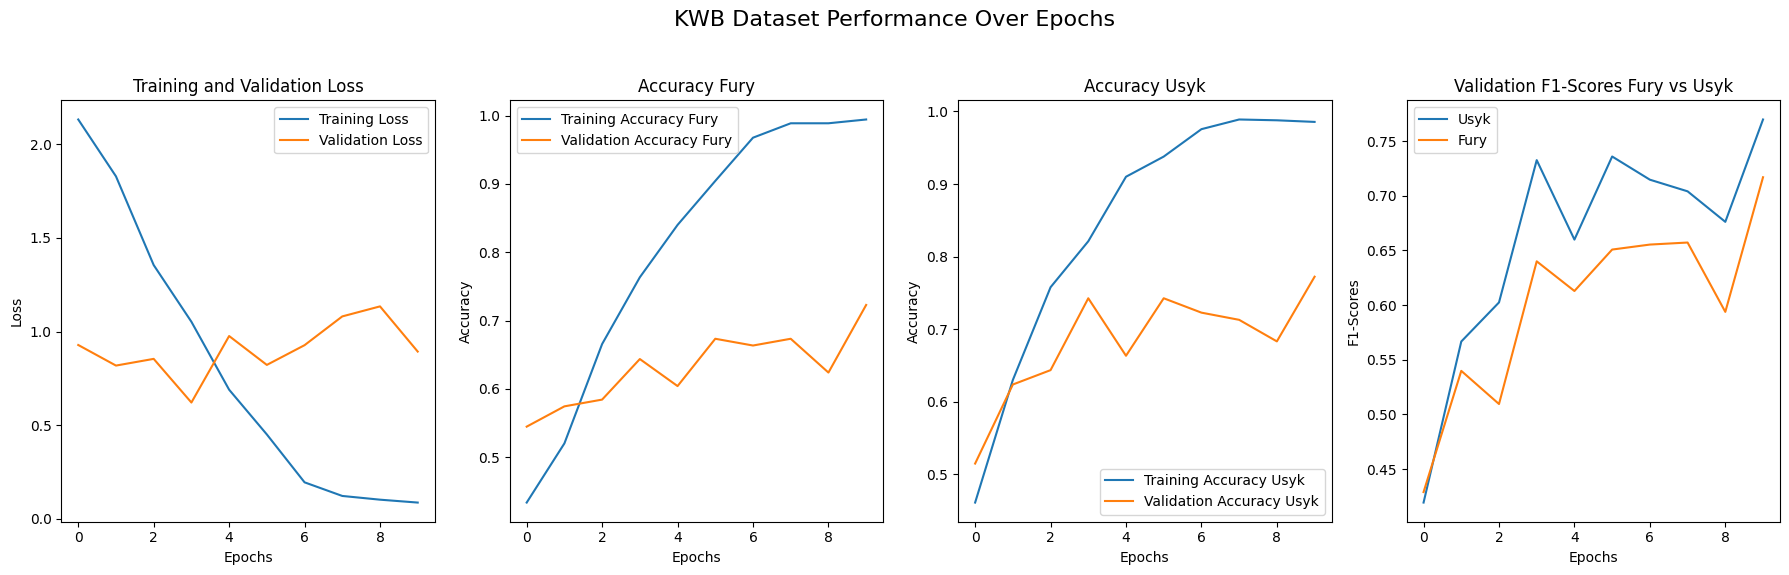

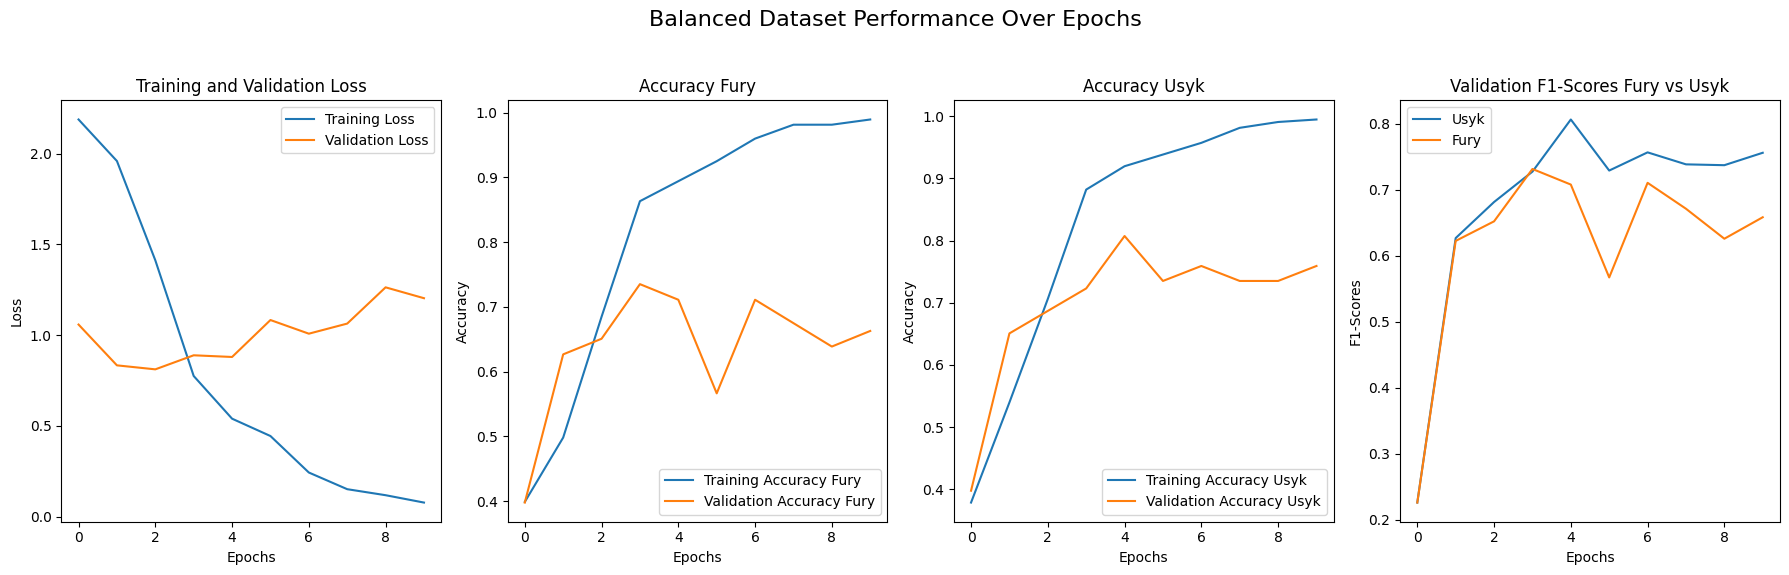

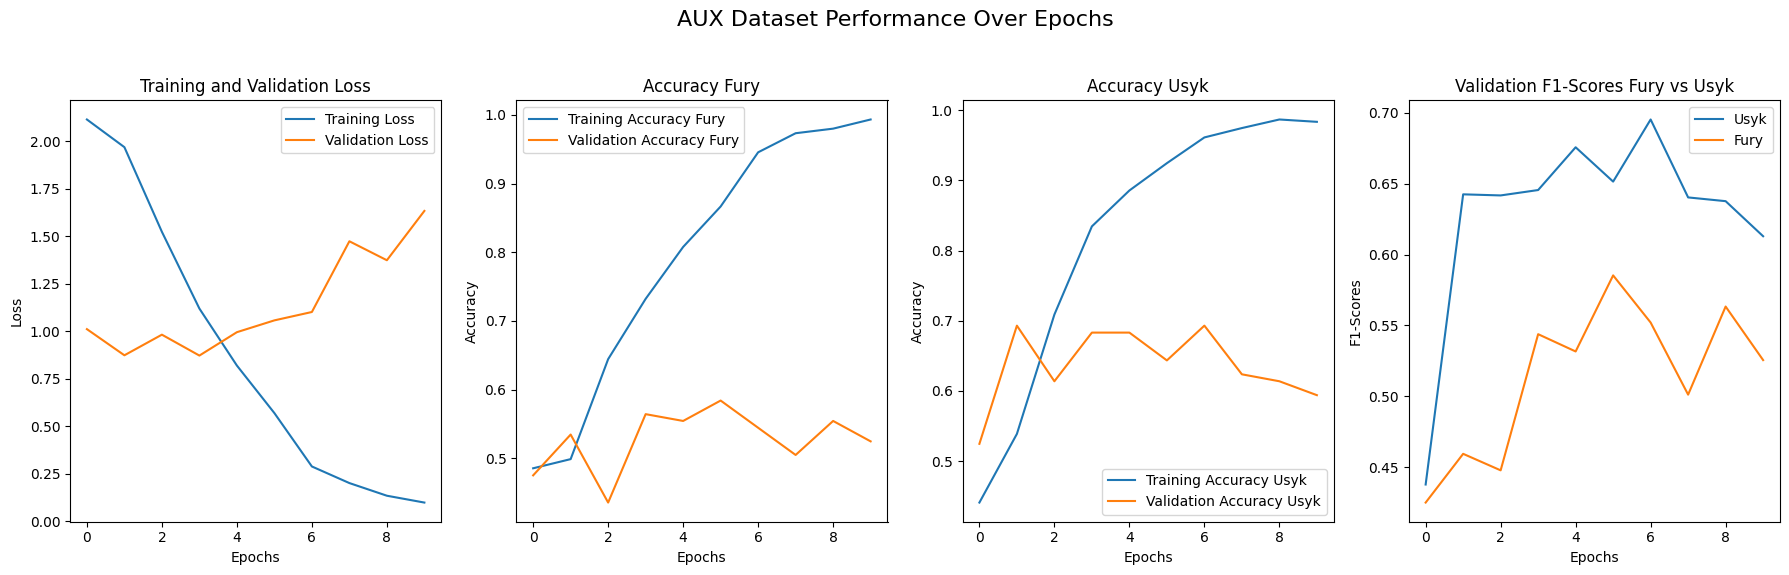

In [35]:
datasets = ["KWB","Balanced","AUX"]
for i in range(len(datasets)):
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns for subplots
    df = pd.read_csv(f"data/results/{datasets[i].lower()}_results.csv")
    train_losses = df["train loss"]
    val_losses = df["val Loss"]
    train_accuracies_fury = df["fury train acc"]
    val_accuracies_fury = df["fury val acc"]
    train_accuracies_usyk = df["usyk train acc"]
    val_accuracies_usyk = df["usyk val acc"]
    f1_usyk = df["usyk f-score"]
    f1_fury = df["fury f-score"]
    # Plot training loss
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plot training accuracies for Fury
    axs[1].plot(train_accuracies_fury, label='Training Accuracy Fury')
    axs[1].plot(val_accuracies_fury, label='Validation Accuracy Fury')
    axs[1].set_title('Accuracy Fury')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    # Plot training accuracies for Usyk
    axs[2].plot(train_accuracies_usyk, label='Training Accuracy Usyk')
    axs[2].plot(val_accuracies_usyk, label='Validation Accuracy Usyk')
    axs[2].set_title('Accuracy Usyk')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()
    
    # Plot val f1-score for Usyk
    axs[3].plot(f1_usyk, label='Usyk')
    axs[3].plot(f1_fury, label='Fury')
    axs[3].set_title('Validation F1-Scores Fury vs Usyk')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('F1-Scores')
    axs[3].legend()
    # Add a common title above all subplots
    fig.suptitle(f'{datasets[i]} Dataset Performance Over Epochs', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make space for suptitle
    plt.show()

## 12. Evaluation

### Model Performance Breakdown by Dataset and Fighter Sentiment

The table provides a comprehensive comparison of sentiment analysis accuracy across various models and datasets. It highlights the performance metrics, specifically the accuracy and F-1 scores, for sentiment classification tasks related to fighters Usyk and Fury.


In [28]:
def create_evaluation_df(results):
    metrics = ['Accuracy', 'F-1']
    models = ['MB+BoW', 'LR+Tf+NGram', 'SVC+Tf+NGram', 'BERT']
    index = pd.MultiIndex.from_product([['KWB', 'Balanced', 'AUX'], ['Usyk', 'Fury']], names=['Dataset', 'Fighter'])
    columns = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

    # Initialize an empty list to hold the 2D array
    array_2d = []
    
    # Iterate through the data to extract and combine 'Usyk' and 'Fury' scores for each dataset
    for dataset, sentiments in results.items():
        row = []
        for sentiment, scores in sentiments.items():
            # print(sentiment, scores)
            # row.extend(scores)
            # scores = [np.round(i, 2) for i in scores]
            # print(scores)
            array_2d.append(scores)
    frame = pd.DataFrame(array_2d, index=index, columns=columns)

    return frame

# Styling function to highlight the best accuracy
def highlight_max(data, color='lightgreen'):
    attr = f'background-color: {color};'
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # DataFrame from .applymap()
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

frame = create_evaluation_df(all_results)
frame = frame.round(2)
frame = frame.applymap(lambda x: f'{x:g}' if isinstance(x, float) else x)
# Apply styling
styled_df = frame.style.apply(highlight_max, axis=0)

# Display the styled DataFrame
styled_df

### Comparative Analysis of Model Accuracy Across Different Datasets

The bar chart visualizes the accuracy of sentiment analysis models for two fighters—Usyk and Fury—across different datasets (KWB, Balanced, AUX) and models (MB+BoW, LR+Tf+NGram, SVC+Tf+NGram, BERT). The models are evaluated on their ability to predict sentiments correctly, and the results are as follows:

- **BERT** outperforms other models with significant margins, achieving the highest accuracy for both fighters across all datasets, peaking at 81% for Usyk in the AUX dataset.
- Traditional machine learning models like **MB+BoW**, **LR+Tf+NGram**, and **SVC+Tf+NGram** show comparable performances, with accuracies generally ranging from mid-50% to mid-60%.
- **Usyk** tends to have slightly higher accuracy scores than **Fury** across the models, indicating potential differences in the comment patterns or clarity between the two fighters' sentiment data.


In [837]:
ds.save_to_csv(frame,"data/results/models_results.csv")

Data saved to: data/results/models_results.csv


In [1001]:
# Filter out only columns that contain 'Accuracy' in their name
accuracy_columns = [col for col in frame.columns if 'Accuracy' in col]

# Select only the accuracy-related columns
accuracy_df = frame[accuracy_columns]

# Melt the filtered DataFrame
melted_accuracy_df = accuracy_df.melt(var_name='Model', value_name='Accuracy')

# Now you can use this melted DataFrame for your seaborn visualizations

melted_accuracy_df['Accuracy'] = melted_accuracy_df['Accuracy'].astype(float)


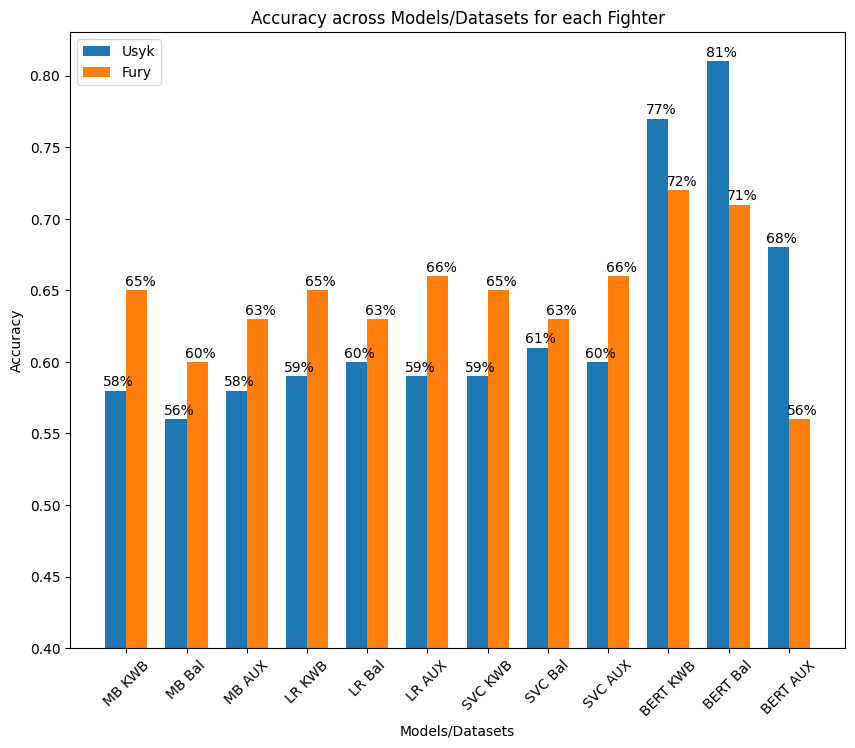

In [992]:
fig, ax = plt.subplots(figsize=(10,8))
bar_width = 0.35
index = np.arange(len(categories))

for i, group in enumerate(groups):
    bars = ax.bar(index + i * bar_width, values[i]-0.4, bar_width, label=group, bottom=0.4)
    # Adding percentage values on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.text((bar.get_x() + 0.05) + bar.get_width() / 2, height+0.401, f'{height+0.4:.0%}', ha='center', va='bottom')
ax.set_xlabel('Models/Datasets')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy across Models/Datasets for each Fighter')
ax.set_xticks(index + bar_width / len(groups))
ax.set_xticklabels(categories)
plt.xticks(rotation=45) 
ax.legend(loc='upper left')

plt.show()

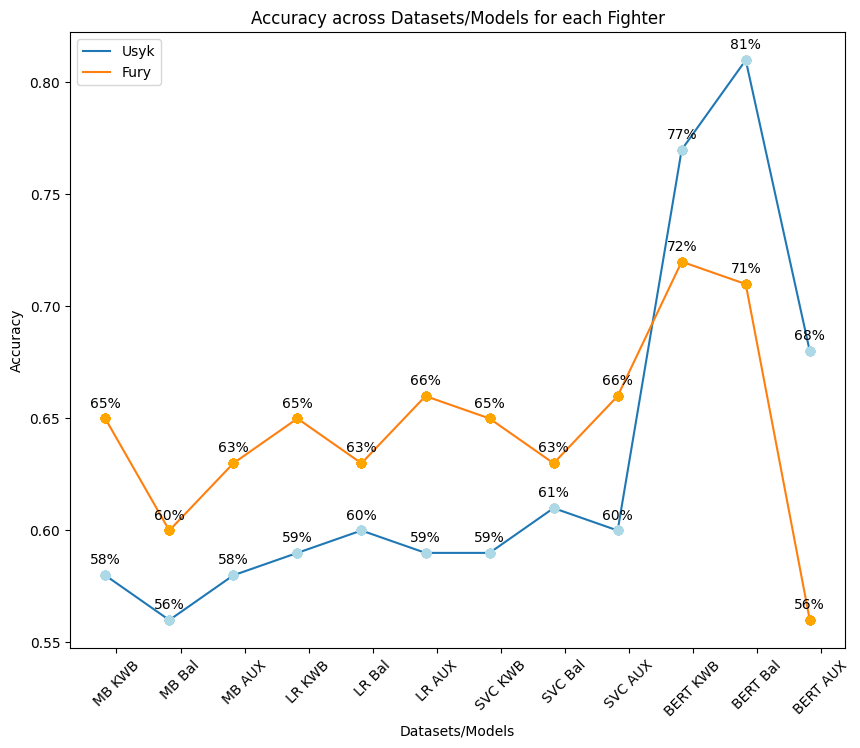

In [1002]:
groups = ['Usyk', 'Fury']
categories = ['MB KWB', 'MB Bal', 'MB AUX',
              'LR KWB', 'LR Bal', 'LR AUX',
             'SVC KWB', 'SVC Bal', 'SVC AUX',
             'BERT KWB', 'BERT Bal', 'BERT AUX']
values = np.array([[0.58, 0.56, 0.58, 0.59, 0.6, 0.59, 0.59, 0.61, 0.6, 0.77, 0.81, 0.68], 
                   [0.65, 0.6, 0.63,0.65, 0.63, 0.66, 0.65, 0.63, 0.66, 0.72, 0.71, 0.56]])
f_scores = np.array([[0.57, 0.57, 0.5, 0.63, 0.54, 0.59, 0.63, 0.58, 0.63, 0.77, 0.81,0.65],
                    [0.65,0.63,0.63, 0.67, 0.7, 0.64, 0.66, 0.67, 0.65, 0.72, 0.71, 0.54]])
fig, ax = plt.subplots(figsize=(10,8))
bar_width = 0.35
index = np.arange(len(categories))

for i, group in enumerate(groups):
    ax.plot(categories, values[i], label=group)
    # Annotate each point on the line
    for x, y in zip(categories, values[i]):
        # Plot points on the lines
        if i == 1:
            color = "orange"
        else:
            color = "lightblue"
        ax.plot(categories, values[i], 'o', color=color)  # 'o' is the marker for a small circle
        ax.text(x, (y+0.005), f'{y:.0%}', color='black', ha='center')
ax.set_xlabel('Datasets/Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy across Datasets/Models for each Fighter')
ax.set_xticks(index + bar_width / len(groups))
ax.set_xticklabels(categories)
plt.xticks(rotation=45) 
ax.legend(loc='upper left')

plt.show()


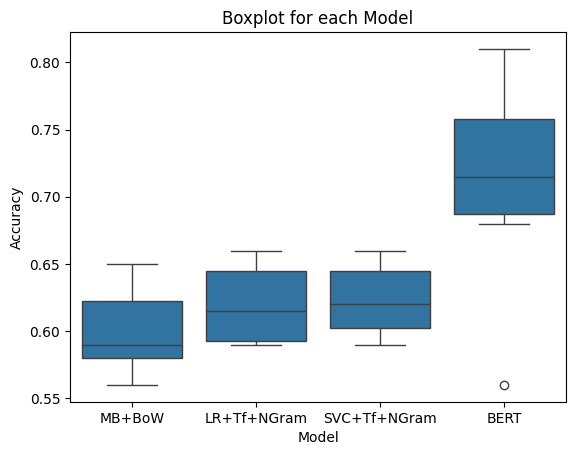

In [1006]:
sns.boxplot(data=melted_accuracy_df, x='Model', y='Accuracy')
plt.title('Boxplot for each Model')
plt.show()